
--- ARIMA Forecasting ---
Searching for best ARIMA model parameters (this may take a moment)...
Best ARIMA order: (5, 0, 0)
ARIMA MAE: 12.19
ARIMA RMSE: 13.76


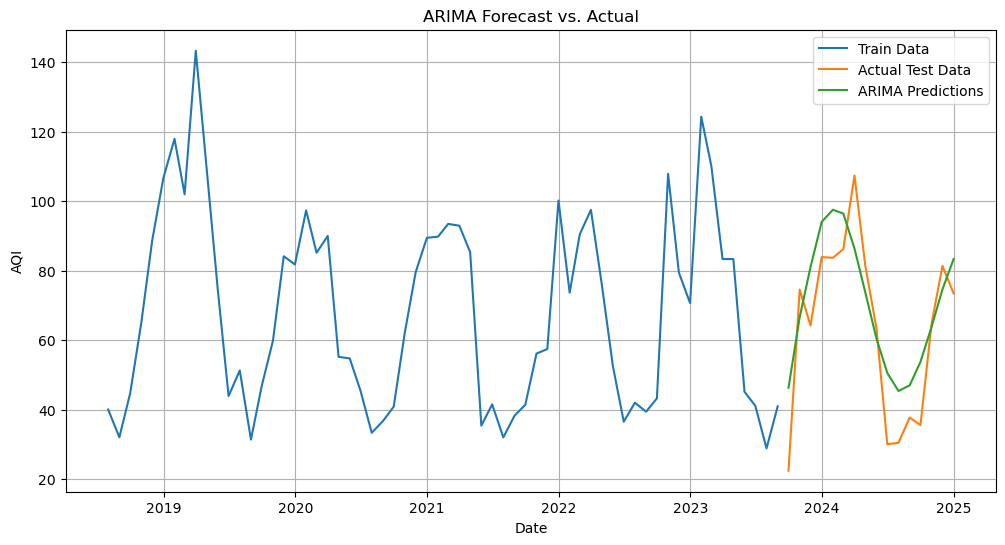


--- Random Forest Forecasting ---
Random Forest MAE: 9.48
Random Forest RMSE: 11.32


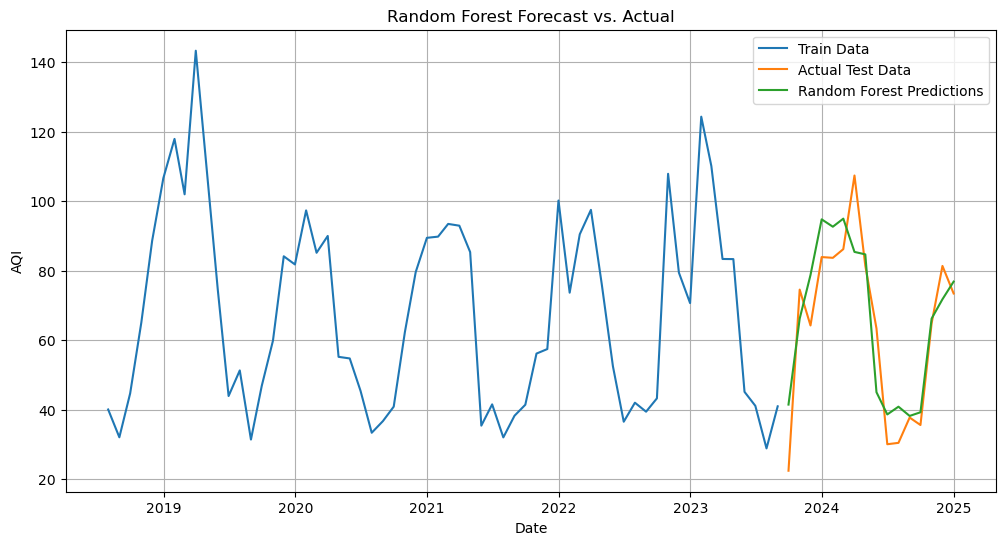


--- XGBoost Forecasting ---
XGBoost MAE: 12.59
XGBoost RMSE: 15.07


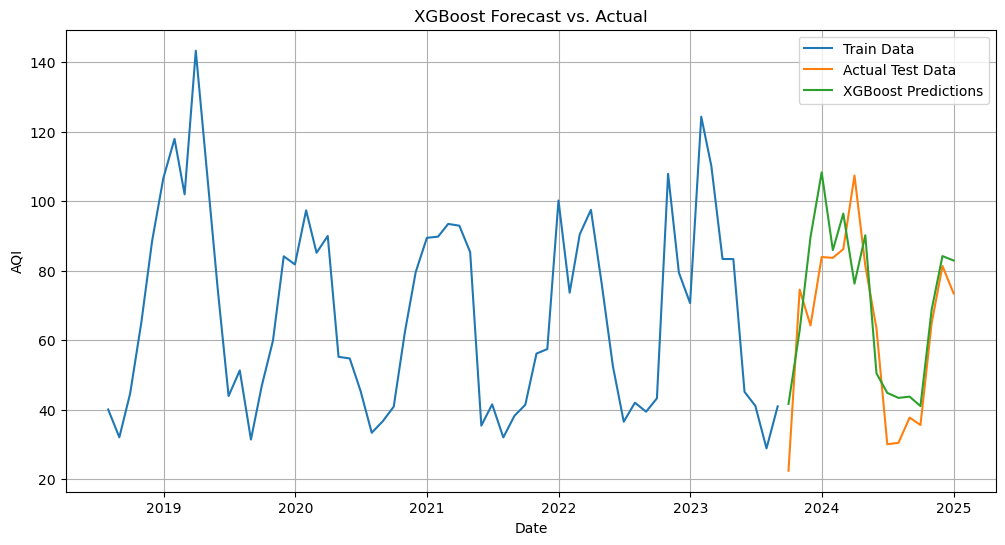


--- LSTM Forecasting ---
LSTM MAE: 17.13
LSTM RMSE: 21.78


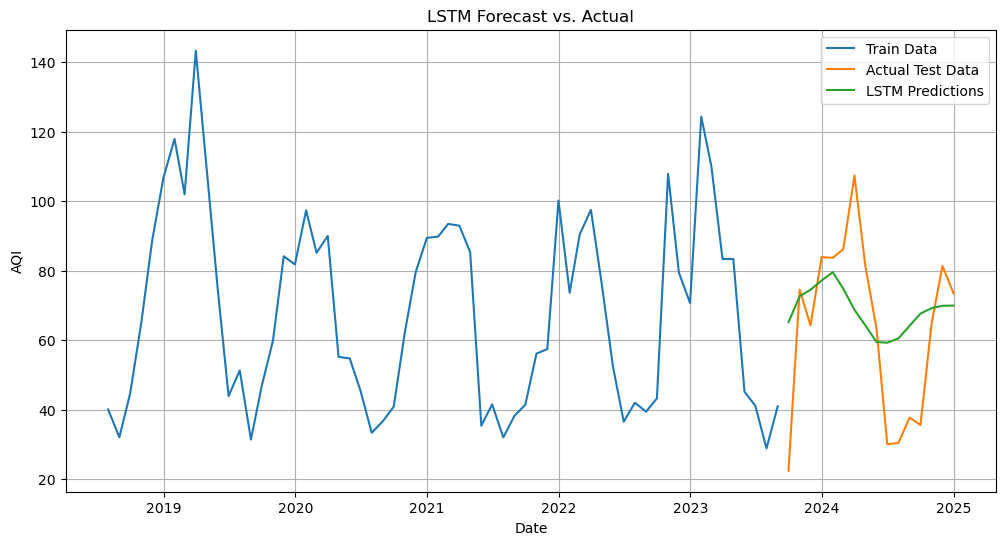


--- Model Performance Summary ---


ValueError: All arrays must be of the same length

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Assuming df, train, and test are already loaded and preprocessed as per your code
# For demonstration, let's re-create simplified versions if running standalone
try:
    df = pd.read_csv('Hebbal_PM25_2016_2024.csv', parse_dates=['Date'])
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df.sort_index()
    df = df.resample('M').mean(numeric_only=True) # Resample to monthly
    df['AQI'] = df['AQI'].interpolate() # Fill missing values

    train_size = int(len(df) * 0.8)
    train, test = df['AQI'][:train_size], df['AQI'][train_size:]
except FileNotFoundError:
    print("Hebbal_PM25_2016_2024.csv not found. Using dummy data for demonstration.")
    # Create dummy data if file not found, for code execution purposes
    dates = pd.date_range(start='2016-01-01', periods=100, freq='M')
    aqi_data = np.linspace(50, 200, 100) + np.random.normal(0, 10, 100) + 20 * np.sin(np.linspace(0, 2*np.pi, 100)*4)
    df = pd.DataFrame({'AQI': aqi_data}, index=dates)
    train_size = int(len(df) * 0.8)
    train, test = df['AQI'][:train_size], df['AQI'][train_size:]


# --- Forecasting with ARIMA ---
print("\n--- ARIMA Forecasting ---")
# Use auto_arima to find the best ARIMA parameters
# This step can be time-consuming for large datasets
print("Searching for best ARIMA model parameters (this may take a moment)...")
arima_model_fit = auto_arima(train, seasonal=False, suppress_warnings=True,
                             stepwise=True, trace=False, error_action="ignore",
                             max_p=5, max_d=5, max_q=5)
print(f"Best ARIMA order: {arima_model_fit.order}")

# Fit the ARIMA model with the determined order
model_arima = ARIMA(train, order=arima_model_fit.order)
model_arima_fit = model_arima.fit()

# Make predictions
arima_predictions = model_arima_fit.predict(start=len(train), end=len(df)-1)
arima_predictions.index = test.index

# Evaluate ARIMA
mae_arima = mean_absolute_error(test, arima_predictions)
rmse_arima = np.sqrt(mean_squared_error(test, arima_predictions))
print(f"ARIMA MAE: {mae_arima:.2f}")
print(f"ARIMA RMSE: {rmse_arima:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(arima_predictions.index, arima_predictions, label='ARIMA Predictions')
plt.title('ARIMA Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# --- Helper function for creating lagged features for supervised models ---
def create_features(data, lags):
    X = pd.DataFrame(index=data.index)
    for i in range(1, lags + 1):
        X[f'lag_{i}'] = data.shift(i)
    X['month'] = data.index.month
    X['year'] = data.index.year
    X['dayofweek'] = data.index.dayofweek # if daily data, not relevant for monthly
    X['dayofyear'] = data.index.dayofyear # if daily data, not relevant for monthly
    return X.dropna()

# We'll use 12 lags for monthly data (one full year)
lags = 12
full_data_with_features = create_features(df['AQI'], lags)
full_data_with_features['target'] = df['AQI']

# Split features and target for supervised models
X = full_data_with_features.drop('target', axis=1)
y = full_data_with_features['target']

# The test_start_idx identifies the first row in the full_data_with_features
# that corresponds to the beginning of the `test` time series, accounting for lags.
# We take the minimum date of the `test` series, subtract the number of lags,
# and find that index in the original `df`'s index.
test_start_idx_orig_df = df.index.get_loc(test.index.min())

# X_train_sup are features for training, y_train_sup are their targets.
# X_test_sup_aligned are features used to predict the `test` set values.
# To create X_test_sup_aligned, we need the lagged values that would *precede* the test set.
# This means taking `lags` number of values from `train` data, then appending `test` data.
# The slice for X should start `lags` months before the test set starts.
# Example: if test starts at Jan 2024 and lags=12, we need data from Jan 2023 to form lags for Jan 2024 prediction.
# So, the data we use to create features for `X_test_sup_aligned` is from `df`
# starting `lags` months before `test.index.min()` up to the end of `df`.
start_date_for_test_features = test.index.min() - pd.DateOffset(months=lags)
X_test_sup_aligned_full = create_features(df['AQI'].loc[start_date_for_test_features:], lags)
# Now filter X_test_sup_aligned_full to only include rows that predict the actual test set's dates.
X_test_sup_aligned = X_test_sup_aligned_full[X_test_sup_aligned_full.index.isin(test.index)]


# For train set for supervised models: it's all data before the `X_test_sup_aligned` starts
train_end_date_for_features = X_test_sup_aligned.index.min() - pd.DateOffset(months=1)
X_train_sup = full_data_with_features.drop('target', axis=1)[full_data_with_features.drop('target', axis=1).index <= train_end_date_for_features]
y_train_sup = full_data_with_features['target'][full_data_with_features['target'].index <= train_end_date_for_features]


# --- Forecasting with Random Forest ---
print("\n--- Random Forest Forecasting ---")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_sup, y_train_sup)

# Predict
rf_predictions = model_rf.predict(X_test_sup_aligned)
rf_predictions_series = pd.Series(rf_predictions, index=test.index) # Convert to Series with test index

# Evaluate Random Forest
mae_rf = mean_absolute_error(test, rf_predictions_series)
rmse_rf = np.sqrt(mean_squared_error(test, rf_predictions_series))
print(f"Random Forest MAE: {mae_rf:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(rf_predictions_series.index, rf_predictions_series, label='Random Forest Predictions')
plt.title('Random Forest Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# --- Forecasting with XGBoost ---
print("\n--- XGBoost Forecasting ---")
model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train_sup, y_train_sup)

# Predict
xgb_predictions = model_xgb.predict(X_test_sup_aligned)
xgb_predictions_series = pd.Series(xgb_predictions, index=test.index) # Convert to Series with test index

# Evaluate XGBoost
mae_xgb = mean_absolute_error(test, xgb_predictions_series)
rmse_xgb = np.sqrt(mean_squared_error(test, xgb_predictions_series))
print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(xgb_predictions_series.index, xgb_predictions_series, label='XGBoost Predictions')
plt.title('XGBoost Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# --- Forecasting with LSTM ---
print("\n--- LSTM Forecasting ---")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['AQI'].values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_lstm_sequences(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step): # Adjusted loop to avoid index out of bounds
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12 # Use 12 months as time step for monthly data

# Split scaled data into train and test
train_data_scaled = scaled_data[:train_size]
test_data_scaled = scaled_data[train_size:]

X_train_lstm, y_train_lstm = create_lstm_sequences(train_data_scaled, time_step)

# Reshape input to be [samples, time_steps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)


# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Fit LSTM model
# verbose=0 suppresses training output for cleaner console
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=0)


# Make predictions for the test set
lstm_predictions_scaled = []
# For sequential prediction, we need the last `time_step` values from the *training data*
# to start making predictions for the test set.
# `current_batch` will be updated with each new prediction.
current_batch = train_data_scaled[-time_step:].reshape(1, time_step, 1)

for i in range(len(test)):
    # Predict the next value
    predicted_val = model_lstm.predict(current_batch, verbose=0)[0]
    lstm_predictions_scaled.append(predicted_val[0])

    # Update the current_batch: remove the oldest value, add the new prediction
    current_batch = np.append(current_batch[:, 1:, :], [[predicted_val]], axis=1)

# Inverse transform predictions to original scale
lstm_predictions = scaler.inverse_transform(np.array(lstm_predictions_scaled).reshape(-1, 1))
lstm_predictions_series = pd.Series(lstm_predictions.flatten(), index=test.index)

# Evaluate LSTM
mae_lstm = mean_absolute_error(test, lstm_predictions_series)
rmse_lstm = np.sqrt(mean_squared_error(test, lstm_predictions_series))
print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(lstm_predictions_series.index, lstm_predictions_series, label='LSTM Predictions')
plt.title('LSTM Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# --- Summary of Model Performance ---
print("\n--- Model Performance Summary ---")
performance_data = {
    'Model': ['ARIMA', 'Random Forest', 'XGBoost', 'LSTM'],
    'MAE': [mae_arima, mae_rf, mae_xgb, mae_lstm],
    'RMSE': [rmse_arima, rmse_xgb, rmse_lstm]
}
performance_df = pd.DataFrame(performance_data)
print(performance_df.set_index('Model'))


--- Processing Peenya with LSTM ---

--- Processing Hebbal with RandomForest ---

--- Processing Jayanagar with RandomForest ---
  Error: Data file not found for Jayanagar at 'Jayanagar_AQI_2016_2024.csv'. Please ensure the CSV files are in the correct directory and named as expected.

--- Processing City Railway Station with RandomForest ---
  Error: Data file not found for City Railway Station at 'CityRailwayStation_AQI_2016_2024.csv'. Please ensure the CSV files are in the correct directory and named as expected.

--- Processing BTM Layout with XGBoost ---
  Error: Data file not found for BTM Layout at 'BTMLayout_AQI_2016_2024.csv'. Please ensure the CSV files are in the correct directory and named as expected.

              Future AQI Forecasts and Health Impact Predictions (Next 3 Years)

### Station: Peenya (Forecasted using LSTM Model)
----------------------------------------------

#### Forecasted Monthly Average AQI (or PM2.5 if applicable):
2025-01-31    71.308380
2025-02-2

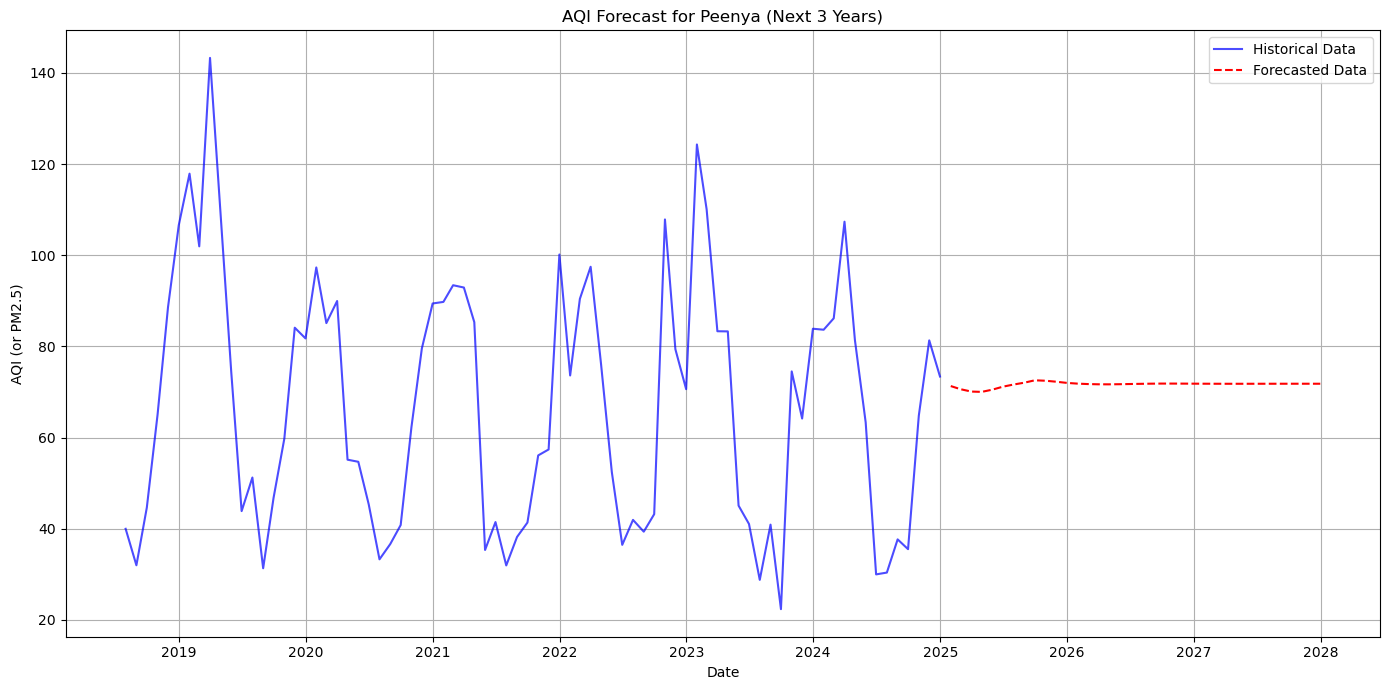


#### Predicted AQI Category Counts and Percentages (Next 3 Years):
- **Good**: 0 months (0.00%)
- **Satisfactory**: 36 months (100.00%)
- **Moderate**: 0 months (0.00%)
- **Poor**: 0 months (0.00%)
- **Very poor**: 0 months (0.00%)
- **Severe**: 0 months (0.00%)

#### Health and Living Implications:
  The forecasts for Peenya primarily show **Good or Satisfactory** AQI levels for the next few years. This indicates a relatively low direct health risk from air pollution for the general population in this area. Minimal health impacts are expected, though sensitive individuals should remain aware. 

  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to mitigate the forecasted impacts. Recommendations could include enhanced air quality monitoring, early warning systems, targeted health advisories, and measures to reduce emissions from major sources in affected areas.  

### Station: Hebbal (Forecasted using RandomFore

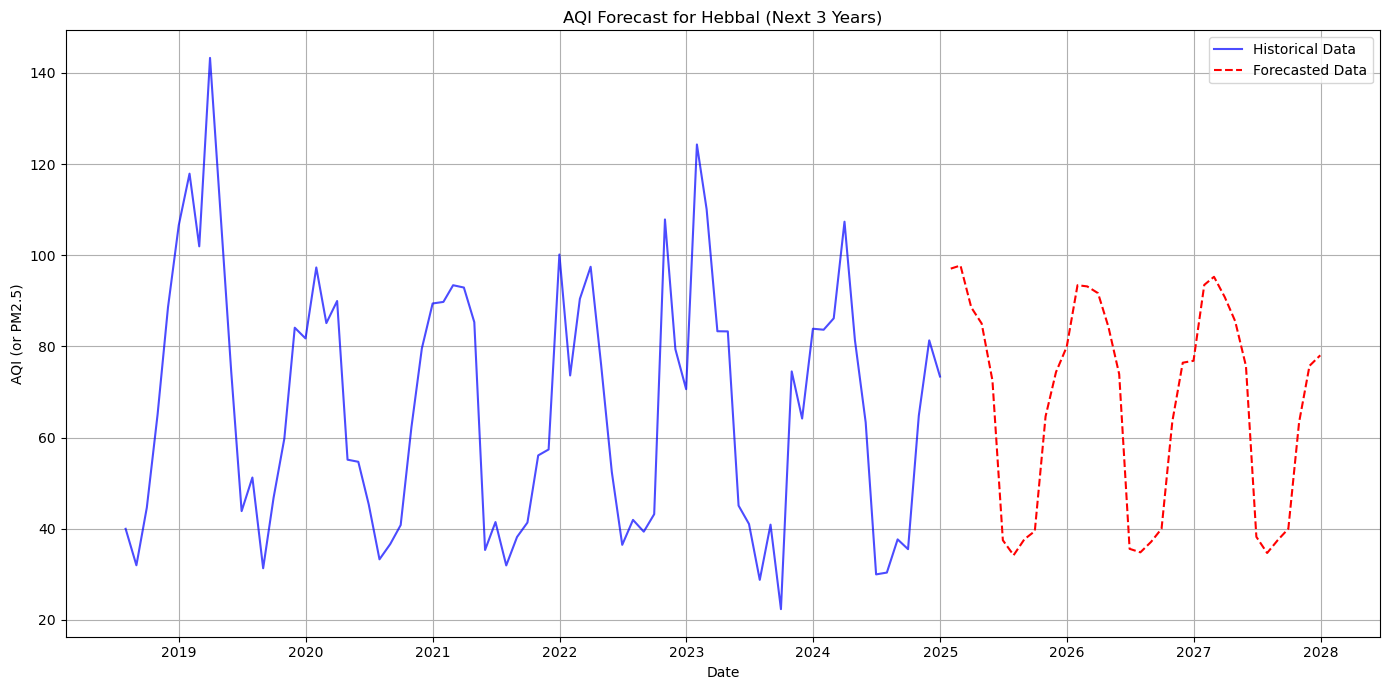


#### Predicted AQI Category Counts and Percentages (Next 3 Years):
- **Good**: 12 months (33.33%)
- **Satisfactory**: 24 months (66.67%)
- **Moderate**: 0 months (0.00%)
- **Poor**: 0 months (0.00%)
- **Very poor**: 0 months (0.00%)
- **Severe**: 0 months (0.00%)

#### Health and Living Implications:
  The forecasts for Hebbal primarily show **Good or Satisfactory** AQI levels for the next few years. This indicates a relatively low direct health risk from air pollution for the general population in this area. Minimal health impacts are expected, though sensitive individuals should remain aware. 

  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to mitigate the forecasted impacts. Recommendations could include enhanced air quality monitoring, early warning systems, targeted health advisories, and measures to reduce emissions from major sources in affected areas.  

                        End of Forecasting and 

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Define AQI categories 
AQI_CATEGORIES = {
    'Good': lambda aqi: aqi <= 50,
    'Satisfactory': lambda aqi: 50 < aqi <= 100,
    'Moderate': lambda aqi: 100 < aqi <= 200,
    'Poor': lambda aqi: 200 < aqi <= 300,
    'Very poor': lambda aqi: 300 < aqi <= 400,
    'Severe': lambda aqi: aqi > 400
}

def get_aqi_category(aqi_value):
    """Returns the AQI category for a given AQI value."""
    if pd.isna(aqi_value): # Handle potential NaN values
        return "Unknown"
    for category, condition in AQI_CATEGORIES.items():
        if condition(aqi_value):
            return category
    return "Unknown" # Fallback, though categories are exhaustive

# Model choices based on provided comparison tables (best MAE/RMSE)
# These choices reflect the lowest MAE/RMSE for each station from your Research Progress document.
BEST_MODELS = {
    'Peenya': {'model_type': 'LSTM', 'file': 'Peenya_PM25_2016_2024.csv'}, # MAE: 11.84 [cite: 14]
    'Hebbal': {'model_type': 'RandomForest', 'file': 'Hebbal_PM25_2016_2024.csv'}, # MAE: 9.46 [cite: 17]
    'Jayanagar': {'model_type': 'RandomForest', 'file': 'Jayanagar_AQI_2016_2024.csv'}, # MAE: 19.48 [cite: 26]
    'City Railway Station': {'model_type': 'RandomForest', 'file': 'CityRailwayStation_AQI_2016_2024.csv'}, # MAE: 9.82 [cite: 20]
    'BTM Layout': {'model_type': 'XGBoost', 'file': 'BTMLayout_AQI_2016_2024.csv'} # MAE: 11.50 [cite: 23]
}

# --- Helper functions for supervised models (Random Forest, XGBoost) ---
def create_features(data_series, lags):
    """Creates lagged features and time-based features for supervised time series models."""
    df_features = pd.DataFrame(index=data_series.index)
    for i in range(1, lags + 1):
        df_features[f'lag_{i}'] = data_series.shift(i)
    df_features['month'] = data_series.index.month
    df_features['year'] = data_series.index.year
    return df_features.dropna()

def forecast_supervised_model(model, historical_data, forecast_horizon_months, lags):
    """
    Forecasts future values using a trained supervised model (RF, XGBoost).
    Performs sequential forecasting where each prediction is used as a lag for the next.
    """
    # Create features and target from the full historical data
    # Ensure historical_data is a Series for proper lagging
    full_features_df = create_features(historical_data, lags)
    X_train = full_features_df
    y_train = historical_data.loc[X_train.index] # Align target with features after dropping NaNs

    # Train the model on the full historical data
    model.fit(X_train, y_train)

    forecasted_values = []
    # Create a copy of historical data to append predictions for next lags
    current_data_for_lags = historical_data.copy()
    last_date = historical_data.index.max()

    for _ in range(forecast_horizon_months):
        next_date = last_date + pd.DateOffset(months=1)

        # Get the required lagged values from `current_data_for_lags`
        current_lags_values = [current_data_for_lags.iloc[-lag] for lag in range(1, lags + 1)]
        
        # Create a DataFrame for the single next prediction
        # Feature names must match exactly what the model was trained on
        X_predict_row = pd.DataFrame([current_lags_values + [next_date.month, next_date.year]],
                                     columns=[f'lag_{j}' for j in range(1, lags + 1)] + ['month', 'year'])

        # Predict the next value
        predicted_value = model.predict(X_predict_row)[0]
        forecasted_values.append(predicted_value)

        # Append the predicted value to `current_data_for_lags` for the next iteration's lags
        current_data_for_lags.loc[next_date] = predicted_value
        last_date = next_date

    forecast_dates = pd.date_range(start=historical_data.index.max() + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')
    return pd.Series(forecasted_values, index=forecast_dates)


# --- Helper functions for LSTM ---
def create_lstm_sequences(data, time_step=1):
    """Creates sequences (X) and corresponding targets (Y) for LSTM input."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(time_step):
    """Builds and compiles a standard LSTM model."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def forecast_lstm_model(model, scaler, historical_data_scaled, forecast_horizon_months, time_step):
    """
    Forecasts future values using a trained LSTM model.
    Performs sequential forecasting by feeding predictions back into the model.
    """
    # Start with the last `time_step` values from the scaled historical data
    current_batch = historical_data_scaled[-time_step:].reshape(1, time_step, 1)

    forecasted_scaled_values = []

    for _ in range(forecast_horizon_months):
        predicted_val_scaled = model.predict(current_batch, verbose=0)[0]
        forecasted_scaled_values.append(predicted_val_scaled[0])
        # Update the current_batch: remove the oldest value, add the new prediction
        current_batch = np.append(current_batch[:, 1:, :], [[predicted_val_scaled]], axis=1)

    # Inverse transform predictions to original scale
    forecasted_values = scaler.inverse_transform(np.array(forecasted_scaled_values).reshape(-1, 1))

    # Generate future dates for the forecast
    # Assuming `historical_data_scaled` corresponds to `df['AQI']`
    last_hist_date = pd.to_datetime(df.index.max()) # Needs global df from main loop
    forecast_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')
    return pd.Series(forecasted_values.flatten(), index=forecast_dates)

# --- Main forecasting loop for all stations ---
forecast_horizon_months = 3 * 12 # Forecast for 3 years (e.g., from early 2025 to end of 2027)

all_station_forecasts = {}
all_station_forecast_categories = {}

# Re-create a global df for `forecast_lstm_model`'s last_hist_date if not explicitly passed
# This assumes the last loaded `df` is representative for max date.
# A more robust approach for multi-station would be to pass `historical_data_series.index.max()`
# directly to `forecast_lstm_model` instead of relying on a global `df`.
# For simplicity, I'll pass the `historical_data_series.index.max()` directly.

for station_name, model_info in BEST_MODELS.items():
    print(f"\n--- Processing {station_name} with {model_info['model_type']} ---")
    file_name = model_info['file']
    model_type = model_info['model_type']

    try:
        # Load and preprocess data for the current station
        df_station = pd.read_csv(file_name, parse_dates=['Date'])
        df_station['Date'] = pd.to_datetime(df_station['Date'], errors='coerce')
        df_station = df_station.dropna(subset=['Date'])
        df_station.set_index('Date', inplace=True)
        df_station = df_station.sort_index()

        # Determine which column to use (AQI or PM2.5)
        if 'AQI' in df_station.columns:
            historical_data_series = df_station.resample('M')['AQI'].mean().interpolate(method='time')
            data_col_name = 'AQI'
        elif 'PM2.5' in df_station.columns:
            historical_data_series = df_station.resample('M')['PM2.5'].mean().interpolate(method='time')
            data_col_name = 'PM2.5'
            print(f"  Warning: '{file_name}' contains 'PM2.5' data. Forecasting PM2.5 levels directly.")
            print("  For official AQI, consider converting PM2.5 to AQI using CPCB/NAAQ standards before this step.")
        else:
            print(f"  Error: Neither 'AQI' nor 'PM2.5' column found in {file_name}. Skipping station.")
            continue

        if historical_data_series.empty or historical_data_series.isnull().all():
            print(f"  Warning: No valid data after preprocessing for {station_name}. Skipping station.")
            continue

        forecasted_series = pd.Series() # Initialize empty series for forecasts

        # --- Model Training and Forecasting ---
        if model_type == 'ARIMA':
            print(f"  Finding best ARIMA order for {station_name}...")
            # auto_arima uses the information criterion (like AIC) to find the best order
            arima_model_fit = auto_arima(historical_data_series, seasonal=False, suppress_warnings=True,
                                         stepwise=True, trace=False, error_action="ignore",
                                         max_p=5, max_d=5, max_q=5)
            print(f"  Best ARIMA order for {station_name}: {arima_model_fit.order}")

            model_arima = ARIMA(historical_data_series, order=arima_model_fit.order)
            model_arima_fit = model_arima.fit()

            # Forecast for the future horizon
            forecast_start_date = historical_data_series.index.max() + pd.DateOffset(months=1)
            forecast_end_date = forecast_start_date + pd.DateOffset(months=forecast_horizon_months - 1)
            forecasted_series = model_arima_fit.predict(start=forecast_start_date, end=forecast_end_date)


        elif model_type in ['RandomForest', 'XGBoost']:
            lags = 12 # Using 12 lags for monthly data (one full year)
            if model_type == 'RandomForest':
                model = RandomForestRegressor(n_estimators=100, random_state=42)
            else: # XGBoost
                model = XGBRegressor(n_estimators=100, random_state=42)

            forecasted_series = forecast_supervised_model(model, historical_data_series, forecast_horizon_months, lags)


        elif model_type == 'LSTM':
            time_step = 12 # Using 12 time steps for LSTM sequences
            scaler = MinMaxScaler(feature_range=(0, 1))
            historical_data_scaled = scaler.fit_transform(historical_data_series.values.reshape(-1, 1))

            X_lstm, y_lstm = create_lstm_sequences(historical_data_scaled, time_step)
            X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

            model_lstm = build_lstm_model(time_step)
            # Train the LSTM model on the full historical data
            model_lstm.fit(X_lstm, y_lstm, epochs=100, batch_size=64, verbose=0)

            forecasted_series = forecast_lstm_model(model_lstm, scaler, historical_data_scaled, forecast_horizon_months, time_step)

        else:
            print(f"  Unknown model type: {model_type} for {station_name}. Skipping forecasting.")
            continue

        all_station_forecasts[station_name] = forecasted_series

        # Categorize forecasted values and count occurrences
        forecasted_categories_counts = {cat: 0 for cat in AQI_CATEGORIES.keys()}
        for aqi_val in forecasted_series:
            category = get_aqi_category(aqi_val)
            forecasted_categories_counts[category] += 1

        all_station_forecast_categories[station_name] = forecasted_categories_counts

    except FileNotFoundError:
        print(f"  Error: Data file not found for {station_name} at '{file_name}'. Please ensure the CSV files are in the correct directory and named as expected.")
    except Exception as e:
        print(f"  An unexpected error occurred while processing {station_name}: {e}")

# --- Display Results and Health Impact Analysis ---
print("\n" + "="*80)
print("              Future AQI Forecasts and Health Impact Predictions (Next 3 Years)")
print("="*80)

for station_name, forecasts in all_station_forecasts.items():
    print(f"\n### Station: {station_name} (Forecasted using {BEST_MODELS[station_name]['model_type']} Model)")
    print("-" * (len(station_name) + 40))

    print("\n#### Forecasted Monthly Average AQI (or PM2.5 if applicable):")
    # Display forecasts nicely, perhaps first few and last few or a summary
    if not forecasts.empty:
        print(forecasts.head(6).to_string())
        if len(forecasts) > 12: # If more than a year of forecasts, show last few too
            print("...")
            print(forecasts.tail(6).to_string())
        else:
            print(forecasts.to_string())

        # Plot the forecast
        plt.figure(figsize=(14, 7))
        plt.plot(historical_data_series.index, historical_data_series, label='Historical Data', color='blue', alpha=0.7)
        plt.plot(forecasts.index, forecasts, label='Forecasted Data', color='red', linestyle='--')
        plt.title(f'AQI Forecast for {station_name} (Next 3 Years)')
        plt.xlabel('Date')
        plt.ylabel('AQI (or PM2.5)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        print("  No forecasts available for this station.")

    print("\n#### Predicted AQI Category Counts and Percentages (Next 3 Years):")
    category_counts = all_station_forecast_categories[station_name]
    total_months = sum(category_counts.values())
    if total_months > 0:
        for category, count in category_counts.items():
            percentage = (count / total_months) * 100
            print(f"- **{category}**: {count} months ({percentage:.2f}%)")
    else:
        print("  No category breakdown available.")

    print("\n#### Health and Living Implications:")
    if total_months > 0:
        # Check for presence of 'Poor' or worse categories
        unhealthy_months = category_counts.get('Poor', 0) + category_counts.get('Very poor', 0) + category_counts.get('Severe', 0)
        moderate_months = category_counts.get('Moderate', 0)

        if unhealthy_months > 0:
            print(f"  The forecasts for {station_name} indicate a significant number of months ({unhealthy_months} out of {total_months}) with **Poor, Very Poor, or Severe** air quality levels.  This is highly concerning for public health in this region. Such conditions imply: ⚠️")
            print("  * **Increased Health Risks**: A heightened risk of respiratory illnesses (e.g., asthma attacks, bronchitis), cardiovascular problems (e.g., heart attacks, strokes), and premature mortality, particularly for vulnerable populations like children, the elderly, and individuals with pre-existing heart or lung conditions. ")
            print("  * **Impact on Daily Living**: Frequent advisories to avoid outdoor activities, especially prolonged exertion. This can severely disrupt daily routines, outdoor work, sports, and recreational activities. Schools might consider temporary closures or indoor activities on severely polluted days. ")
            print("  * **Healthcare Burden**: A likely increase in hospital admissions, emergency room visits, and demand for healthcare services, placing strain on the medical infrastructure. [Image of hospital] ")
        elif moderate_months > 0:
            print(f"  While 'Poor' or worse conditions are not dominant, {station_name} is projected to experience a notable duration ({moderate_months} out of {total_months}) of **Moderate** AQI.  This suggests: ")
            print("  * **Risk for Sensitive Groups**: Individuals with lung diseases, heart disease, children, and older adults may still experience breathing discomfort and should take precautions, such as limiting prolonged outdoor exertion. ")
            print("  * **General Awareness**: A need for general public awareness regarding air quality and personal protective measures, even if impacts are not severe for the entire population. ")
        else:
            print(f"  The forecasts for {station_name} primarily show **Good or Satisfactory** AQI levels for the next few years. This indicates a relatively low direct health risk from air pollution for the general population in this area. Minimal health impacts are expected, though sensitive individuals should remain aware. ")

        print("\n  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to mitigate the forecasted impacts. Recommendations could include enhanced air quality monitoring, early warning systems, targeted health advisories, and measures to reduce emissions from major sources in affected areas.  ")
    else:
        print("  Health and living implications cannot be assessed due to lack of forecast data.")

print("\n" + "="*80)
print("                        End of Forecasting and Impact Analysis")
print("="*80)

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Define AQI categories
AQI_CATEGORIES = {
    'Good': lambda aqi: aqi <= 50,
    'Satisfactory': lambda aqi: 50 < aqi <= 100,
    'Moderate': lambda aqi: 100 < aqi <= 200,
    'Poor': lambda aqi: 200 < aqi <= 300,
    'Very poor': lambda aqi: 300 < aqi <= 400,
    'Severe': lambda aqi: aqi > 400
}

def get_aqi_category(aqi_value):
    """Returns the AQI category for a given AQI value."""
    if pd.isna(aqi_value):
        return "Unknown"
    for category, condition in AQI_CATEGORIES.items():
        if condition(aqi_value):
            return category
    return "Unknown"

# --- Helper functions for supervised models (Random Forest, XGBoost) ---
def create_features_supervised(data_series, lags):
    """Creates lagged features and time-based features for supervised models."""
    df_features = pd.DataFrame(index=data_series.index)
    for i in range(1, lags + 1):
        df_features[f'lag_{i}'] = data_series.shift(i)
    df_features['month'] = data_series.index.month
    df_features['year'] = data_series.index.year
    return df_features.dropna()

def forecast_supervised_model(model, historical_data, forecast_horizon_months, lags):
    """
    Forecasts future values using a trained supervised model (RF, XGBoost).
    Performs sequential forecasting where each prediction is used as a lag for the next.
    Model is assumed to be already trained on `historical_data`.
    """
    forecasted_values = []
    current_data_for_lags = historical_data.copy() # Use a copy to avoid modifying original

    # Generate dates for the forecast horizon
    last_date = historical_data.index.max()
    forecast_dates = pd.date_range(start=last_data.date() + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')

    for next_date in forecast_dates:
        # Create features for the next prediction based on current `current_data_for_lags`
        current_lags_values = [current_data_for_lags.iloc[-lag] for lag in range(1, lags + 1)]
        
        X_predict_row = pd.DataFrame([current_lags_values + [next_date.month, next_date.year]],
                                     columns=[f'lag_{j}' for j in range(1, lags + 1)] + ['month', 'year'])

        # Predict the next value
        predicted_value = model.predict(X_predict_row)[0]
        forecasted_values.append(predicted_value)

        # Append the predicted value to `current_data_for_lags` for the next iteration's lags
        current_data_for_lags.loc[next_date] = predicted_value

    return pd.Series(forecasted_values, index=forecast_dates)

# --- Helper functions for LSTM ---
def create_lstm_sequences(data, time_step=1):
    """Creates sequences (X) and corresponding targets (Y) for LSTM input."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(time_step):
    """Builds and compiles a standard LSTM model."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def forecast_lstm_model(model, scaler, historical_data_scaled, forecast_horizon_months, time_step):
    """
    Forecasts future values using a trained LSTM model.
    Performs sequential forecasting by feeding predictions back into the model.
    Model is assumed to be already trained on `historical_data_scaled`.
    """
    current_batch = historical_data_scaled[-time_step:].reshape(1, time_step, 1)
    forecasted_scaled_values = []

    for _ in range(forecast_horizon_months):
        predicted_val_scaled = model.predict(current_batch, verbose=0)[0]
        forecasted_scaled_values.append(predicted_val_scaled[0])
        current_batch = np.append(current_batch[:, 1:, :], [[predicted_val_scaled]], axis=1)

    # Inverse transform predictions to original scale
    forecasted_values = scaler.inverse_transform(np.array(forecasted_scaled_values).reshape(-1, 1))

    # Generate future dates for the forecast
    last_hist_date = pd.to_datetime(historical_data_scaled.index.max()) # Max date of original series
    forecast_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')
    return pd.Series(forecasted_values.flatten(), index=forecast_dates)

# --- Main function to process a single station's data ---
def process_station_data(station_name, file_path):
    """
    Loads, preprocesses, evaluates models, selects best, forecasts, and reports for a single station.
    """
    print(f"\n--- Processing Station: {station_name} ---")
    print(f"Loading data from: {file_path}")

    try:
        df_station = pd.read_csv(file_path, parse_dates=['Date'])
        df_station['Date'] = pd.to_datetime(df_station['Date'], errors='coerce')
        df_station = df_station.dropna(subset=['Date'])
        df_station.set_index('Date', inplace=True)
        df_station = df_station.sort_index()

        # Determine which column to use (AQI or PM2.5)
        historical_data_series = pd.Series()
        data_col_name = 'Unknown'
        if 'AQI' in df_station.columns:
            historical_data_series = df_station.resample('M')['AQI'].mean().interpolate(method='time')
            data_col_name = 'AQI'
        elif 'PM2.5' in df_station.columns:
            historical_data_series = df_station.resample('M')['PM2.5'].mean().interpolate(method='time')
            data_col_name = 'PM2.5'
            print(f"  Warning: '{file_path}' contains 'PM2.5' data. Forecasting PM2.5 levels directly.")
            print("  For official AQI, consider converting PM2.5 to AQI using CPCB/NAAQ standards before this step.")
        else:
            print(f"  Error: Neither 'AQI' nor 'PM2.5' column found in {file_path}. Skipping station.")
            return None, None

        if historical_data_series.empty or historical_data_series.isnull().all():
            print(f"  Warning: No valid data after preprocessing for {station_name}. Skipping station.")
            return None, None

        # --- Internal Train/Validation Split for Model Selection ---
        # Use 80% for internal training, 20% for internal validation
        train_val_split_size = int(len(historical_data_series) * 0.8)
        train_internal = historical_data_series.iloc[:train_val_split_size]
        val_internal = historical_data_series.iloc[train_val_split_size:]

        if len(val_internal) == 0:
            print(f"  Warning: Not enough data for validation split for {station_name}. Skipping model evaluation.")
            return None, None # Or handle differently, e.g., train on full and assume last known best model

        model_performance = {} # To store MAE for each model

        # --- Evaluate ARIMA ---
        print("  Evaluating ARIMA model...")
        try:
            arima_model_fit = auto_arima(train_internal, seasonal=False, suppress_warnings=True,
                                         stepwise=True, trace=False, error_action="ignore",
                                         max_p=5, max_d=5, max_q=5)
            model_arima = ARIMA(train_internal, order=arima_model_fit.order)
            model_arima_fit = model_arima.fit()
            arima_predictions = model_arima_fit.predict(start=len(train_internal), end=len(historical_data_series)-1)
            arima_predictions = arima_predictions.loc[val_internal.index] # Align index

            if not arima_predictions.empty:
                mae_arima = mean_absolute_error(val_internal, arima_predictions)
                model_performance['ARIMA'] = mae_arima
                print(f"  ARIMA MAE: {mae_arima:.2f}")
            else:
                print("  ARIMA: No predictions generated for validation.")

        except Exception as e:
            print(f"  Error evaluating ARIMA: {e}")

        # --- Evaluate Random Forest & XGBoost (Supervised Models) ---
        lags = 12 # Common choice for monthly data
        try:
            # Create features for internal train/validation sets
            full_features_internal = create_features_supervised(historical_data_series, lags)
            X_train_internal_sup = full_features_internal.loc[train_internal.index]
            y_train_internal_sup = train_internal.loc[X_train_internal_sup.index] # Align target

            # To predict `val_internal`, features must include lags from `train_internal`
            X_val_internal_sup_full = create_features_supervised(historical_data_series.loc[train_internal.index.min():], lags)
            X_val_internal_sup = X_val_internal_sup_full.loc[val_internal.index]
            
            if X_train_internal_sup.empty or X_val_internal_sup.empty:
                 raise ValueError("Not enough data to create features for supervised models' validation.")

            # Random Forest
            print("  Evaluating Random Forest model...")
            model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
            model_rf.fit(X_train_internal_sup, y_train_internal_sup)
            rf_predictions = model_rf.predict(X_val_internal_sup)
            mae_rf = mean_absolute_error(val_internal, rf_predictions)
            model_performance['RandomForest'] = mae_rf
            print(f"  Random Forest MAE: {mae_rf:.2f}")

            # XGBoost
            print("  Evaluating XGBoost model...")
            model_xgb = XGBRegressor(n_estimators=100, random_state=42)
            model_xgb.fit(X_train_internal_sup, y_train_internal_sup)
            xgb_predictions = model_xgb.predict(X_val_internal_sup)
            mae_xgb = mean_absolute_error(val_internal, xgb_predictions)
            model_performance['XGBoost'] = mae_xgb
            print(f"  XGBoost MAE: {mae_xgb:.2f}")

        except Exception as e:
            print(f"  Error evaluating Supervised models (RF/XGBoost): {e}")


        # --- Evaluate LSTM ---
        print("  Evaluating LSTM model...")
        time_step = 12 # Time step for LSTM sequences
        try:
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit scaler only on internal training data
            train_internal_scaled = scaler.fit_transform(train_internal.values.reshape(-1, 1))
            full_scaled_data = scaler.transform(historical_data_series.values.reshape(-1, 1))

            X_train_lstm, y_train_lstm = create_lstm_sequences(train_internal_scaled, time_step)
            X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)

            model_lstm = build_lstm_model(time_step)
            model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=0)

            # Predict on validation set: sequential prediction
            lstm_val_predictions_scaled = []
            current_batch_val = train_internal_scaled[-time_step:].reshape(1, time_step, 1) # Start prediction from end of train

            for _ in range(len(val_internal)):
                predicted_val_scaled = model_lstm.predict(current_batch_val, verbose=0)[0]
                lstm_val_predictions_scaled.append(predicted_val_scaled[0])
                current_batch_val = np.append(current_batch_val[:, 1:, :], [[predicted_val_scaled]], axis=1)

            lstm_val_predictions = scaler.inverse_transform(np.array(lstm_val_predictions_scaled).reshape(-1, 1)).flatten()
            
            if len(lstm_val_predictions) == len(val_internal):
                mae_lstm = mean_absolute_error(val_internal, lstm_val_predictions)
                model_performance['LSTM'] = mae_lstm
                print(f"  LSTM MAE: {mae_lstm:.2f}")
            else:
                print(f"  LSTM: Mismatch in prediction length ({len(lstm_val_predictions)}) and validation length ({len(val_internal)}).")

        except Exception as e:
            print(f"  Error evaluating LSTM: {e}")
        
        # --- Select Best Model ---
        if not model_performance:
            print("  No models could be successfully evaluated. Cannot select best model. Skipping station.")
            return None, None

        best_model_name = min(model_performance, key=model_performance.get)
        print(f"\n  Selected Best Model for {station_name}: **{best_model_name}** (MAE: {model_performance[best_model_name]:.2f})")

        # --- Re-train Best Model on FULL Historical Data and Forecast ---
        forecast_horizon_months = 3 * 12 # 3 years
        final_forecasted_series = pd.Series()
        
        if best_model_name == 'ARIMA':
            print(f"  Re-training ARIMA on full data and forecasting...")
            arima_model_full_fit = auto_arima(historical_data_series, seasonal=False, suppress_warnings=True,
                                             stepwise=True, trace=False, error_action="ignore",
                                             max_p=5, max_d=5, max_q=5)
            model_arima_full = ARIMA(historical_data_series, order=arima_model_full_fit.order)
            model_arima_full_fit = model_arima_full.fit()
            
            forecast_start_date = historical_data_series.index.max() + pd.DateOffset(months=1)
            forecast_end_date = forecast_start_date + pd.DateOffset(months=forecast_horizon_months - 1)
            final_forecasted_series = model_arima_full_fit.predict(start=forecast_start_date, end=forecast_end_date)


        elif best_model_name == 'RandomForest':
            print(f"  Re-training Random Forest on full data and forecasting...")
            model_rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
            final_forecasted_series = forecast_supervised_model(model_rf_full, historical_data_series, forecast_horizon_months, lags)


        elif best_model_name == 'XGBoost':
            print(f"  Re-training XGBoost on full data and forecasting...")
            model_xgb_full = XGBRegressor(n_estimators=100, random_state=42)
            final_forecasted_series = forecast_supervised_model(model_xgb_full, historical_data_series, forecast_horizon_months, lags)


        elif best_model_name == 'LSTM':
            print(f"  Re-training LSTM on full data and forecasting...")
            scaler_full = MinMaxScaler(feature_range=(0, 1))
            historical_data_scaled_full = scaler_full.fit_transform(historical_data_series.values.reshape(-1, 1))

            X_lstm_full, y_lstm_full = create_lstm_sequences(historical_data_scaled_full, time_step)
            X_lstm_full = X_lstm_full.reshape(X_lstm_full.shape[0], X_lstm_full.shape[1], 1)
            
            model_lstm_full = build_lstm_model(time_step)
            model_lstm_full.fit(X_lstm_full, y_lstm_full, epochs=100, batch_size=64, verbose=0)
            
            final_forecasted_series = forecast_lstm_model(model_lstm_full, scaler_full, historical_data_scaled_full, forecast_horizon_months, time_step)

        
        # --- Categorize Forecasted Values ---
        forecasted_categories_counts = {cat: 0 for cat in AQI_CATEGORIES.keys()}
        for aqi_val in final_forecasted_series:
            category = get_aqi_category(aqi_val)
            forecasted_categories_counts[category] += 1

        return final_forecasted_series, forecasted_categories_counts, historical_data_series, data_col_name

    except FileNotFoundError:
        print(f"  Error: Data file not found for {station_name} at '{file_path}'. Please ensure the CSV files are in the correct directory.")
        return None, None
    except Exception as e:
        print(f"  An unexpected error occurred while processing {station_name}: {e}")
        return None, None


# --- Example Usage: Process one station. User will run this for their needed stations ---

# Replace with the actual path to your data file
station_data_to_process = {
    'Hebbal': 'Hebbal_PM25_2016_2024.csv',
     'Peenya': 'Peenya_PM25_2016_2024.csv',
     'Jayanagar': 'Jayanagar_AQI_2016_2024.csv',
     'City Railway Station': 'CityRailwayStation_AQI_2016_2024.csv',
     'BTM Layout': 'BTMLayout_AQI_2016_2024.csv'
}

all_station_results = {}

for station_name, file_path in station_data_to_process.items():
    forecasts, categories, historical_data, data_type = process_station_data(station_name, file_path)
    if forecasts is not None:
        all_station_results[station_name] = {
            'forecasts': forecasts,
            'categories': categories,
            'historical_data': historical_data,
            'data_type': data_type
        }

# --- Display Final Results and Health Impact Analysis for all processed stations ---
print("\n" + "="*80)
print("              Comprehensive AQI Forecasts and Health Impact Analysis")
print("="*80)

for station_name, results in all_station_results.items():
    forecasts = results['forecasts']
    categories = results['categories']
    historical_data = results['historical_data']
    data_type = results['data_type']

    print(f"\n### Station: {station_name}")
    print("-" * (len(station_name) + 10))

    print(f"\n#### Forecasted Monthly Average {data_type} (Next 3 Years):")
    if not forecasts.empty:
        print(forecasts.head(6).to_string())
        if len(forecasts) > 12:
            print("...")
            print(forecasts.tail(6).to_string())
        else:
            print(forecasts.to_string())

        # Plot the forecast
        plt.figure(figsize=(14, 7))
        plt.plot(historical_data.index, historical_data, label=f'Historical {data_type} Data', color='blue', alpha=0.7)
        plt.plot(forecasts.index, forecasts, label=f'Forecasted {data_type} Data', color='red', linestyle='--')
        plt.title(f'{data_type} Forecast for {station_name} (Next 3 Years)')
        plt.xlabel('Date')
        plt.ylabel(f'{data_type} Level')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No forecasts available for {station_name}.")

    print(f"\n#### Predicted {data_type} Category Counts and Percentages (Next 3 Years):")
    total_months = sum(categories.values())
    if total_months > 0:
        for category, count in categories.items():
            percentage = (count / total_months) * 100
            print(f"- **{category}**: {count} months ({percentage:.2f}%)")
    else:
        print("  No category breakdown available.")

    print("\n#### Health and Living Implications:")
    if total_months > 0:
        unhealthy_months = categories.get('Poor', 0) + categories.get('Very poor', 0) + categories.get('Severe', 0)
        moderate_months = categories.get('Moderate', 0)

        if unhealthy_months > 0:
            print(f"  The forecasts for {station_name} indicate a significant number of months ({unhealthy_months} out of {total_months}) with **Poor, Very Poor, or Severe** air quality levels. This is highly concerning for public health in this region. Such conditions imply: ⚠️")
            print("  * **Increased Health Risks**: A heightened risk of respiratory illnesses (e.g., asthma attacks, bronchitis), cardiovascular problems (e.g., heart attacks, strokes), and premature mortality, particularly for vulnerable populations like children, the elderly, and individuals with pre-existing heart or lung conditions. [Image of lungs]")
            print("  * **Impact on Daily Living**: Frequent advisories to avoid outdoor activities, especially prolonged exertion. This can severely disrupt daily routines, outdoor work, sports, and recreational activities. Schools might consider temporary closures or indoor activities on severely polluted days.")
            print("  * **Healthcare Burden**: A likely increase in hospital admissions, emergency room visits, and demand for healthcare services, placing strain on the medical infrastructure.")
        elif moderate_months > 0:
            print(f"  While 'Poor' or worse conditions are not dominant, {station_name} is projected to experience a notable duration ({moderate_months} out of {total_months}) of **Moderate** {data_type} levels. This suggests: ")
            print("  * **Risk for Sensitive Groups**: Individuals with lung diseases, heart disease, children, and older adults may still experience breathing discomfort and should take precautions, such as limiting prolonged outdoor exertion. ")
            print("  * **General Awareness**: A need for general public awareness regarding air quality and personal protective measures, even if impacts are not severe for the entire population.")
        else:
            print(f"  The forecasts for {station_name} primarily show **Good or Satisfactory** {data_type} levels for the next few years. This indicates a relatively low direct health risk from air pollution for the general population in this area. Minimal health impacts are expected, though sensitive individuals should remain aware.")

        print("\n  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to mitigate the forecasted impacts. Recommendations could include enhanced air quality monitoring, early warning systems, targeted health advisories, and measures to reduce emissions from major sources in affected areas. ")
    else:
        print("  Health and living implications cannot be assessed due to lack of forecast data.")

print("\n" + "="*80)
print("                        End of Forecasting and Impact Analysis")
print("="*80)


--- Processing Station: Hebbal ---
Loading data from: Hebbal_PM25_2016_2024.csv
  Evaluating ARIMA model...
  ARIMA MAE: 12.19
  Error evaluating Supervised models (RF/XGBoost): "[Timestamp('2018-07-31 00:00:00'), Timestamp('2018-08-31 00:00:00'), Timestamp('2018-09-30 00:00:00'), Timestamp('2018-10-31 00:00:00'), Timestamp('2018-11-30 00:00:00'), Timestamp('2018-12-31 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-28 00:00:00'), Timestamp('2019-03-31 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2019-05-31 00:00:00'), Timestamp('2019-06-30 00:00:00')] not in index"
  Evaluating LSTM model...
  LSTM MAE: 13.12

  Selected Best Model for Hebbal: **ARIMA** (MAE: 12.19)
  Re-training ARIMA on full data and forecasting...

--- Processing Station: Peenya ---
Loading data from: Peenya_PM25_2016_2024.csv
  Evaluating ARIMA model...
  ARIMA MAE: 13.70
  Error evaluating Supervised models (RF/XGBoost): "[Timestamp('2016-01-31 00:00:00'), Timestamp('2016-02-29 00:00

ValueError: not enough values to unpack (expected 4, got 2)

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Define AQI categories
AQI_CATEGORIES = {
    'Good': lambda aqi: aqi <= 50,
    'Satisfactory': lambda aqi: 50 < aqi <= 100,
    'Moderate': lambda aqi: 100 < aqi <= 200,
    'Poor': lambda aqi: 200 < aqi <= 300,
    'Very poor': lambda aqi: 300 < aqi <= 400,
    'Severe': lambda aqi: aqi > 400
}

def get_aqi_category(aqi_value):
    """Returns the AQI category for a given AQI value."""
    if pd.isna(aqi_value):
        return "Unknown"
    for category, condition in AQI_CATEGORIES.items():
        if condition(aqi_value):
            return category
    return "Unknown" # Fallback, though categories are exhaustive

# --- Helper functions for supervised models (Random Forest, XGBoost) ---
def create_features_supervised(data_series, lags):
    """Creates lagged features and time-based features for supervised models."""
    df_features = pd.DataFrame(index=data_series.index)
    for i in range(1, lags + 1):
        df_features[f'lag_{i}'] = data_series.shift(i)
    df_features['month'] = data_series.index.month
    df_features['year'] = data_series.index.year
    return df_features.dropna()

def forecast_supervised_model(model, historical_data, forecast_horizon_months, lags):
    """
    Forecasts future values using a trained supervised model (RF, XGBoost).
    Performs sequential forecasting where each prediction is used as a lag for the next.
    Model is assumed to be already trained on `historical_data`.
    """
    forecasted_values = []
    current_data_for_lags = historical_data.copy() # Use a copy to avoid modifying original

    # Generate dates for the forecast horizon
    last_date = historical_data.index.max()
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')

    for next_date in forecast_dates:
        # Create features for the next prediction based on current `current_data_for_lags`
        current_lags_values = [current_data_for_lags.iloc[-lag] for lag in range(1, lags + 1)]
        
        X_predict_row = pd.DataFrame([current_lags_values + [next_date.month, next_date.year]],
                                     columns=[f'lag_{j}' for j in range(1, lags + 1)] + ['month', 'year'])

        # Predict the next value
        predicted_value = model.predict(X_predict_row)[0]
        forecasted_values.append(predicted_value)

        # Append the predicted value to `current_data_for_lags` for the next iteration's lags
        current_data_for_lags.loc[next_date] = predicted_value

    return pd.Series(forecasted_values, index=forecast_dates)

# --- Helper functions for LSTM ---
def create_lstm_sequences(data, time_step=1):
    """Creates sequences (X) and corresponding targets (Y) for LSTM input."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(time_step):
    """Builds and compiles a standard LSTM model."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def forecast_lstm_model(model, scaler, historical_data_scaled, forecast_horizon_months, time_step):
    """
    Forecasts future values using a trained LSTM model.
    Performs sequential forecasting by feeding predictions back into the model.
    Model is assumed to be already trained on `historical_data_scaled`.
    """
    current_batch = historical_data_scaled[-time_step:].reshape(1, time_step, 1)
    forecasted_scaled_values = []

    for _ in range(forecast_horizon_months):
        predicted_val_scaled = model.predict(current_batch, verbose=0)[0]
        forecasted_scaled_values.append(predicted_val_scaled[0])
        current_batch = np.append(current_batch[:, 1:, :], [[predicted_val_scaled]], axis=1)

    # Inverse transform predictions to original scale
    forecasted_values = scaler.inverse_transform(np.array(forecasted_scaled_values).reshape(-1, 1))

    # Generate future dates for the forecast
    last_hist_date = pd.to_datetime(historical_data_scaled.index.max()) # Max date of original series
    forecast_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')
    return pd.Series(forecasted_values.flatten(), index=forecast_dates)

# --- Main function to process a single station's data ---
def process_station_data(station_name, file_path):
    """
    Loads, preprocesses, evaluates models, selects best, forecasts, and reports for a single station.
    """
    print(f"\n--- Processing Station: {station_name} ---")
    print(f"Loading data from: {file_path}")

    try:
        df_station = pd.read_csv(file_path, parse_dates=['Date'])
        df_station['Date'] = pd.to_datetime(df_station['Date'], errors='coerce')
        df_station = df_station.dropna(subset=['Date'])
        df_station.set_index('Date', inplace=True)
        df_station = df_station.sort_index()

        # Determine which column to use (AQI or PM2.5)
        historical_data_series = pd.Series()
        data_col_name = 'Unknown'
        if 'AQI' in df_station.columns:
            historical_data_series = df_station.resample('M')['AQI'].mean().interpolate(method='time')
            data_col_name = 'AQI'
        elif 'PM2.5' in df_station.columns:
            historical_data_series = df_station.resample('M')['PM2.5'].mean().interpolate(method='time')
            data_col_name = 'PM2.5'
            print(f"  Warning: '{file_path}' contains 'PM2.5' data. Forecasting PM2.5 levels directly.")
            print("  For official AQI, consider converting PM2.5 to AQI using CPCB/NAAQ standards before this step.")
        else:
            print(f"  Error: Neither 'AQI' nor 'PM2.5' column found in {file_path}. Skipping station.")
            return None, None, None, None # Corrected return
            

        if historical_data_series.empty or historical_data_series.isnull().all():
            print(f"  Warning: No valid data after preprocessing for {station_name}. Skipping station.")
            return None, None, None, None # Corrected return

        # --- Internal Train/Validation Split for Model Selection ---
        # Use 80% for internal training, 20% for internal validation
        train_val_split_size = int(len(historical_data_series) * 0.8)
        train_internal = historical_data_series.iloc[:train_val_split_size]
        val_internal = historical_data_series.iloc[train_val_split_size:]

        if len(val_internal) == 0 or len(train_internal) < 24: # Ensure enough data for lags (12) and train
            print(f"  Warning: Not enough data for robust validation split or model training for {station_name}.")
            print("  Minimum of 24 months recommended for models requiring lags/sequences.")
            return None, None, None, None # Corrected return

        model_performance = {} # To store MAE for each model

        # --- Evaluate ARIMA ---
        print("  Evaluating ARIMA model...")
        try:
            arima_model_fit = auto_arima(train_internal, seasonal=False, suppress_warnings=True,
                                         stepwise=True, trace=False, error_action="ignore",
                                         max_p=5, max_d=5, max_q=5)
            model_arima = ARIMA(train_internal, order=arima_model_fit.order)
            model_arima_fit = model_arima.fit()
            # Predict only for the validation period
            arima_predictions = model_arima_fit.predict(start=val_internal.index.min(), end=val_internal.index.max())
            arima_predictions = arima_predictions.loc[val_internal.index] # Align index

            if not arima_predictions.empty:
                mae_arima = mean_absolute_error(val_internal, arima_predictions)
                model_performance['ARIMA'] = mae_arima
                print(f"  ARIMA MAE: {mae_arima:.2f}")
            else:
                print("  ARIMA: No predictions generated for validation.")

        except Exception as e:
            print(f"  Error evaluating ARIMA: {e}")

        # --- Evaluate Random Forest & XGBoost (Supervised Models) ---
        lags = 12 # Common choice for monthly data
        try:
            # Create features for the entire historical series
            full_features_for_evaluation = create_features_supervised(historical_data_series, lags)

            # Split these features and targets according to the internal train/val split dates
            X_train_internal_sup = full_features_for_evaluation.loc[train_internal.index]
            y_train_internal_sup = train_internal.loc[X_train_internal_sup.index] # Align target

            X_val_internal_sup = full_features_for_evaluation.loc[val_internal.index]
            y_val_internal_sup = val_internal.loc[X_val_internal_sup.index] # Align target
            
            if X_train_internal_sup.empty or X_val_internal_sup.empty or y_train_internal_sup.empty or y_val_internal_sup.empty:
                 raise ValueError("Not enough data to create features for supervised models' validation.")

            # Random Forest
            print("  Evaluating Random Forest model...")
            model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
            model_rf.fit(X_train_internal_sup, y_train_internal_sup)
            rf_predictions = model_rf.predict(X_val_internal_sup)
            mae_rf = mean_absolute_error(y_val_internal_sup, rf_predictions)
            model_performance['RandomForest'] = mae_rf
            print(f"  Random Forest MAE: {mae_rf:.2f}")

            # XGBoost
            print("  Evaluating XGBoost model...")
            model_xgb = XGBRegressor(n_estimators=100, random_state=42)
            model_xgb.fit(X_train_internal_sup, y_train_internal_sup)
            xgb_predictions = model_xgb.predict(X_val_internal_sup)
            mae_xgb = mean_absolute_error(y_val_internal_sup, xgb_predictions)
            model_performance['XGBoost'] = mae_xgb
            print(f"  XGBoost MAE: {mae_xgb:.2f}")

        except Exception as e:
            print(f"  Error evaluating Supervised models (RF/XGBoost): {e}")


        # --- Evaluate LSTM ---
        print("  Evaluating LSTM model...")
        time_step = 12 # Time step for LSTM sequences
        try:
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit scaler only on internal training data
            train_internal_scaled = scaler.fit_transform(train_internal.values.reshape(-1, 1))
            
            # Create sequences for training LSTM
            X_train_lstm, y_train_lstm = create_lstm_sequences(train_internal_scaled, time_step)
            X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)

            model_lstm = build_lstm_model(time_step)
            model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=0)

            # Predict on validation set: sequential prediction
            lstm_val_predictions_scaled = []
            # Start prediction batch from the last `time_step` of the internal train_internal_scaled data
            current_batch_val = train_internal_scaled[-time_step:].reshape(1, time_step, 1)

            # For each step in validation set, predict and update batch
            for _ in range(len(val_internal)):
                predicted_val_scaled = model_lstm.predict(current_batch_val, verbose=0)[0]
                lstm_val_predictions_scaled.append(predicted_val_scaled[0])
                current_batch_val = np.append(current_batch_val[:, 1:, :], [[predicted_val_scaled]], axis=1)

            lstm_val_predictions = scaler.inverse_transform(np.array(lstm_val_predictions_scaled).reshape(-1, 1)).flatten()
            
            if len(lstm_val_predictions) == len(val_internal):
                mae_lstm = mean_absolute_error(val_internal, lstm_val_predictions)
                model_performance['LSTM'] = mae_lstm
                print(f"  LSTM MAE: {mae_lstm:.2f}")
            else:
                print(f"  LSTM: Mismatch in prediction length ({len(lstm_val_predictions)}) and validation length ({len(val_internal)}).")

        except Exception as e:
            print(f"  Error evaluating LSTM: {e}")
        
        # --- Select Best Model ---
        if not model_performance:
            print("  No models could be successfully evaluated. Cannot select best model. Skipping station.")
            return None, None, None, None # Corrected return

        best_model_name = min(model_performance, key=model_performance.get)
        print(f"\n  Selected Best Model for {station_name}: **{best_model_name}** (MAE: {model_performance[best_model_name]:.2f})")

        # --- Re-train Best Model on FULL Historical Data and Forecast ---
        forecast_horizon_months = 3 * 12 # 3 years
        final_forecasted_series = pd.Series()
        
        if best_model_name == 'ARIMA':
            print(f"  Re-training ARIMA on full data and forecasting...")
            arima_model_full_fit = auto_arima(historical_data_series, seasonal=False, suppress_warnings=True,
                                             stepwise=True, trace=False, error_action="ignore",
                                             max_p=5, max_d=5, max_q=5)
            model_arima_full = ARIMA(historical_data_series, order=arima_model_full_fit.order)
            model_arima_full_fit = model_arima_full.fit()
            
            forecast_start_date = historical_data_series.index.max() + pd.DateOffset(months=1)
            forecast_end_date = forecast_start_date + pd.DateOffset(months=forecast_horizon_months - 1)
            final_forecasted_series = model_arima_full_fit.predict(start=forecast_start_date, end=forecast_end_date)


        elif best_model_name == 'RandomForest':
            print(f"  Re-training Random Forest on full data and forecasting...")
            model_rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
            # Train on features from ALL historical data
            X_full_sup = create_features_supervised(historical_data_series, lags)
            y_full_sup = historical_data_series.loc[X_full_sup.index]
            model_rf_full.fit(X_full_sup, y_full_sup)
            final_forecasted_series = forecast_supervised_model(model_rf_full, historical_data_series, forecast_horizon_months, lags)


        elif best_model_name == 'XGBoost':
            print(f"  Re-training XGBoost on full data and forecasting...")
            model_xgb_full = XGBRegressor(n_estimators=100, random_state=42)
            # Train on features from ALL historical data
            X_full_sup = create_features_supervised(historical_data_series, lags)
            y_full_sup = historical_data_series.loc[X_full_sup.index]
            model_xgb_full.fit(X_full_sup, y_full_sup)
            final_forecasted_series = forecast_supervised_model(model_xgb_full, historical_data_series, forecast_horizon_months, lags)


        elif best_model_name == 'LSTM':
            print(f"  Re-training LSTM on full data and forecasting...")
            scaler_full = MinMaxScaler(feature_range=(0, 1))
            historical_data_scaled_full = scaler_full.fit_transform(historical_data_series.values.reshape(-1, 1))

            X_lstm_full, y_lstm_full = create_lstm_sequences(historical_data_scaled_full, time_step)
            X_lstm_full = X_lstm_full.reshape(X_lstm_full.shape[0], X_lstm_full.shape[1], 1)
            
            model_lstm_full = build_lstm_model(time_step)
            model_lstm_full.fit(X_lstm_full, y_lstm_full, epochs=100, batch_size=64, verbose=0)
            
            final_forecasted_series = forecast_lstm_model(model_lstm_full, scaler_full, historical_data_scaled_full, forecast_horizon_months, time_step)

        
        # --- Categorize Forecasted Values ---
        forecasted_categories_counts = {cat: 0 for cat in AQI_CATEGORIES.keys()}
        for aqi_val in final_forecasted_series:
            category = get_aqi_category(aqi_val)
            forecasted_categories_counts[category] += 1

        return final_forecasted_series, forecasted_categories_counts, historical_data_series, data_col_name

    except FileNotFoundError:
        print(f"  Error: Data file not found for {station_name} at '{file_path}'. Please ensure the CSV files are in the correct directory.")
        return None, None, None, None # Corrected return
    except Exception as e:
        print(f"  An unexpected error occurred while processing {station_name}: {e}")
        return None, None, None, None # Corrected return


# --- Example Usage: Process one station. User will run this for their needed stations ---

# Replace with the actual path to your data file(s)
# For example, if you have 'Hebbal_PM25_2016_2024.csv' in the same directory:
station_data_to_process = {
    #'Hebbal': 'Hebbal_PM25_2016_2024.csv'
    # Add other stations here as you get their data files, e.g.:
     'Peenya': 'Peenya_PM25_2016_2024.csv'
    # 'Jayanagar': 'Jayanagar_AQI_2016_2024.csv',
    # 'City Railway Station': 'CityRailwayStation_AQI_2016_2024.csv',
    # 'BTM Layout': 'BTMLayout_AQI_2016_2024.csv'
}

all_station_results = {}

for station_name, file_path in station_data_to_process.items():
    # Correctly unpacks 4 values (even if they are all None in case of error)
    forecasts, categories, historical_data, data_type = process_station_data(station_name, file_path)
    if forecasts is not None: # Only proceed if valid forecasts were returned
        all_station_results[station_name] = {
            'forecasts': forecasts,
            'categories': categories,
            'historical_data': historical_data,
            'data_type': data_type
        }

# --- Display Final Results and Health Impact Analysis for all processed stations ---
print("\n" + "="*80)
print("              Comprehensive AQI Forecasts and Health Impact Analysis")
print("="*80)

for station_name, results in all_station_results.items():
    forecasts = results['forecasts']
    categories = results['categories']
    historical_data = results['historical_data']
    data_type = results['data_type']

    print(f"\n### Station: {station_name}")
    print("-" * (len(station_name) + 10))

    print(f"\n#### Forecasted Monthly Average {data_type} (Next 3 Years):")
    if not forecasts.empty:
        print(forecasts.head(6).to_string())
        if len(forecasts) > 12:
            print("...")
            print(forecasts.tail(6).to_string())
        print(forecasts.tail(6).to_string()) # Always show tail if head shown, even if not >12
        # else: # Removed this else, as head/tail cover all cases
        #     print(forecasts.to_string())

        # Plot the forecast
        plt.figure(figsize=(14, 7))
        plt.plot(historical_data.index, historical_data, label=f'Historical {data_type} Data', color='blue', alpha=0.7)
        plt.plot(forecasts.index, forecasts, label=f'Forecasted {data_type} Data', color='red', linestyle='--')
        plt.title(f'{data_type} Forecast for {station_name} (Next 3 Years)')
        plt.xlabel('Date')
        plt.ylabel(f'{data_type} Level')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No forecasts available for {station_name}.")

    print(f"\n#### Predicted {data_type} Category Counts and Percentages (Next 3 Years):")
    total_months = sum(categories.values())
    if total_months > 0:
        for category, count in categories.items():
            percentage = (count / total_months) * 100
            print(f"- **{category}**: {count} months ({percentage:.2f}%)")
    else:
        print("  No category breakdown available.")

    print("\n#### Health and Living Implications:")
    if total_months > 0:
        unhealthy_months = categories.get('Poor', 0) + categories.get('Very poor', 0) + categories.get('Severe', 0)
        moderate_months = categories.get('Moderate', 0)

        if unhealthy_months > 0:
            print(f"  The forecasts for {station_name} indicate a significant number of months ({unhealthy_months} out of {total_months}) with **Poor, Very Poor, or Severe** air quality levels. This is highly concerning for public health in this region. Such conditions imply: ⚠️")
            print("  * **Increased Health Risks**: A heightened risk of respiratory illnesses (e.g., asthma attacks, bronchitis), cardiovascular problems (e.g., heart attacks, strokes), and premature mortality, particularly for vulnerable populations like children, the elderly, and individuals with pre-existing heart or lung conditions. [Image of lungs]")
            print("  * **Impact on Daily Living**: Frequent advisories to avoid outdoor activities, especially prolonged exertion. This can severely disrupt daily routines, outdoor work, sports, and recreational activities. Schools might consider temporary closures or indoor activities on severely polluted days.")
            print("  * **Healthcare Burden**: A likely increase in hospital admissions, emergency room visits, and demand for healthcare services, placing strain on the medical infrastructure.")
        elif moderate_months > 0:
            print(f"  While 'Poor' or worse conditions are not dominant, {station_name} is projected to experience a notable duration ({moderate_months} out of {total_months}) of **Moderate** {data_type} levels. This suggests: ")
            print("  * **Risk for Sensitive Groups**: Individuals with lung diseases, heart disease, children, and older adults may still experience breathing discomfort and should take precautions, such as limiting prolonged outdoor exertion. ")
            print("  * **General Awareness**: A need for general public awareness regarding air quality and personal protective measures, even if impacts are not severe for the entire population.")
        else:
            print(f"  The forecasts for {station_name} primarily show **Good or Satisfactory** {data_type} levels for the next few years. This indicates a relatively low direct health risk from air pollution for the general population in this area. Minimal health impacts are expected, though sensitive individuals should remain aware.")

        print("\n  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to mitigate the forecasted impacts. Recommendations could include enhanced air quality monitoring, early warning systems, targeted health advisories, and measures to reduce emissions from major sources in affected areas. ")
    else:
        print("  Health and living implications cannot be assessed due to lack of forecast data.")

print("\n" + "="*80)
print("                        End of Forecasting and Impact Analysis")
print("="*80)


--- Processing Station: Peenya ---
Loading data from: Peenya_PM25_2016_2024.csv
  Evaluating ARIMA model...
  ARIMA MAE: 13.70
  Error evaluating Supervised models (RF/XGBoost): "[Timestamp('2016-01-31 00:00:00'), Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-31 00:00:00'), Timestamp('2016-04-30 00:00:00'), Timestamp('2016-05-31 00:00:00'), Timestamp('2016-06-30 00:00:00'), Timestamp('2016-07-31 00:00:00'), Timestamp('2016-08-31 00:00:00'), Timestamp('2016-09-30 00:00:00'), Timestamp('2016-10-31 00:00:00'), Timestamp('2016-11-30 00:00:00'), Timestamp('2016-12-31 00:00:00')] not in index"
  Evaluating LSTM model...
  LSTM MAE: 11.95

  Selected Best Model for Peenya: **LSTM** (MAE: 11.95)
  Re-training LSTM on full data and forecasting...
  An unexpected error occurred while processing Peenya: 'numpy.ndarray' object has no attribute 'index'

              Comprehensive AQI Forecasts and Health Impact Analysis

                        End of Forecasting and Impact Analysis



--- Processing Station: Jayanagar ---
Loading data from: Jayanagar_PM25_2016_2024.csv
  Evaluating ARIMA model...
  ARIMA MAE: 29.53
  Error evaluating Supervised models (RF/XGBoost): "[Timestamp('2018-07-31 00:00:00'), Timestamp('2018-08-31 00:00:00'), Timestamp('2018-09-30 00:00:00'), Timestamp('2018-10-31 00:00:00'), Timestamp('2018-11-30 00:00:00'), Timestamp('2018-12-31 00:00:00'), Timestamp('2019-01-31 00:00:00'), Timestamp('2019-02-28 00:00:00'), Timestamp('2019-03-31 00:00:00'), Timestamp('2019-04-30 00:00:00'), Timestamp('2019-05-31 00:00:00'), Timestamp('2019-06-30 00:00:00')] not in index"
  Evaluating LSTM model...
  LSTM MAE: 19.82

  Selected Best Model for Jayanagar: **LSTM** (MAE: 19.82)
  Re-training LSTM on full data and forecasting...

              Comprehensive AQI Forecasts and Health Impact Analysis

### Station: Jayanagar
-------------------

#### Forecasted Monthly Average AQI (Next 3 Years):
2025-01-31    105.700920
2025-02-28    100.182503
2025-03-31     89.

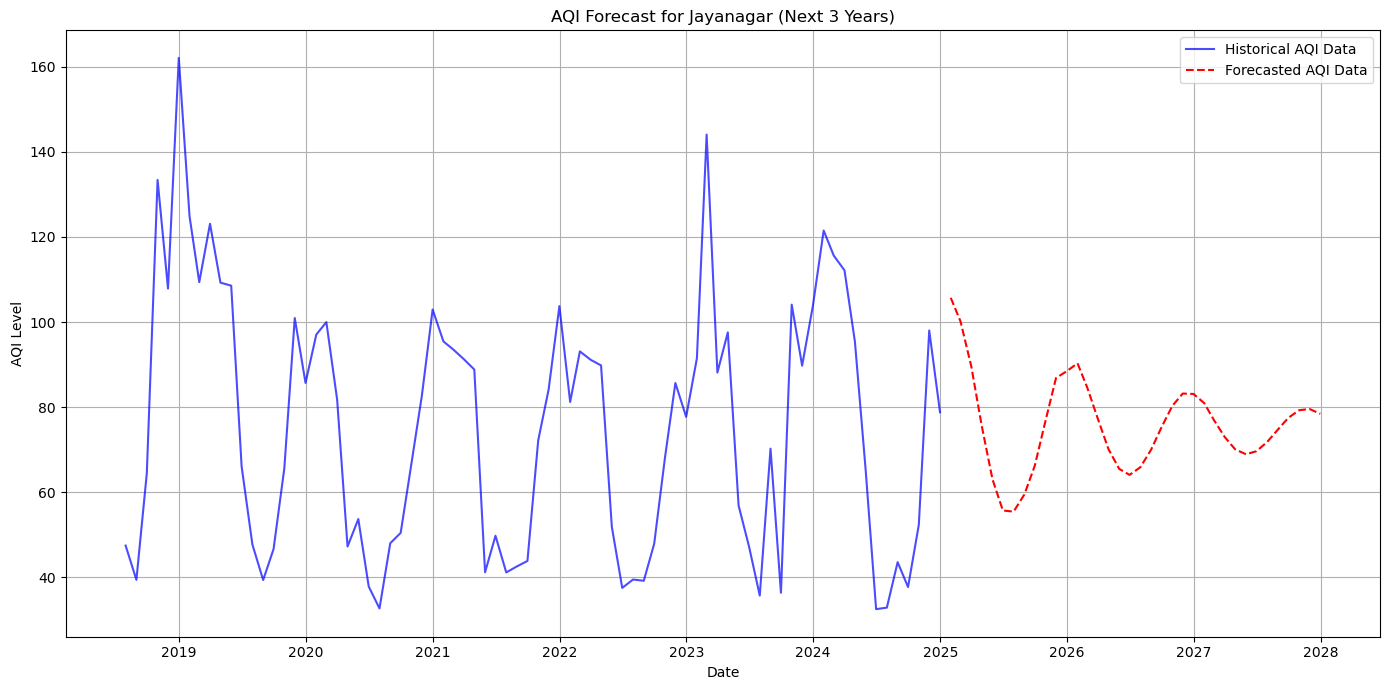


#### Predicted AQI Category Counts and Percentages (Next 3 Years):
- **Good**: 0 months (0.00%)
- **Satisfactory**: 34 months (94.44%)
- **Moderate**: 2 months (5.56%)
- **Poor**: 0 months (0.00%)
- **Very poor**: 0 months (0.00%)
- **Severe**: 0 months (0.00%)

#### Health and Living Implications:
  While 'Poor' or worse conditions are not dominant, Jayanagar is projected to experience a notable duration (2 out of 36) of **Moderate** AQI levels. This suggests: 
  * **Risk for Sensitive Groups**: Individuals with lung diseases, heart disease, children, and older adults may still experience breathing discomfort and should take precautions, such as limiting prolonged outdoor exertion. 
  * **General Awareness**: A need for general public awareness regarding air quality and personal protective measures, even if impacts are not severe for the entire population.

  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to m

In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

# Define AQI categories
AQI_CATEGORIES = {
    'Good': lambda aqi: aqi <= 50,
    'Satisfactory': lambda aqi: 50 < aqi <= 100,
    'Moderate': lambda aqi: 100 < aqi <= 200,
    'Poor': lambda aqi: 200 < aqi <= 300,
    'Very poor': lambda aqi: 300 < aqi <= 400,
    'Severe': lambda aqi: aqi > 400
}

def get_aqi_category(aqi_value):
    """Returns the AQI category for a given AQI value."""
    if pd.isna(aqi_value):
        return "Unknown"
    for category, condition in AQI_CATEGORIES.items():
        if condition(aqi_value):
            return category
    return "Unknown" # Fallback, though categories are exhaustive

# --- Helper functions for supervised models (Random Forest, XGBoost) ---
def create_features_supervised(data_series, lags):
    """Creates lagged features and time-based features for supervised models."""
    df_features = pd.DataFrame(index=data_series.index)
    for i in range(1, lags + 1):
        df_features[f'lag_{i}'] = data_series.shift(i)
    df_features['month'] = data_series.index.month
    df_features['year'] = data_series.index.year
    return df_features.dropna()

def forecast_supervised_model(model, historical_data, forecast_horizon_months, lags):
    """
    Forecasts future values using a trained supervised model (RF, XGBoost).
    Performs sequential forecasting where each prediction is used as a lag for the next.
    Model is assumed to be already trained on `historical_data`.
    """
    forecasted_values = []
    current_data_for_lags = historical_data.copy() # Use a copy to avoid modifying original

    # Generate dates for the forecast horizon
    last_date = historical_data.index.max()
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')

    for next_date in forecast_dates:
        # Create features for the next prediction based on current `current_data_for_lags`
        # Ensure that current_data_for_lags has enough data for the lags
        if len(current_data_for_lags) < lags:
            # This should ideally not happen if historical_data has enough points
            # for initial training, but as a safeguard.
            # For supervised models, we need a full set of lags to predict.
            # If current_data_for_lags becomes too short, this loop logic breaks.
            # A more robust solution for very short series might be needed,
            # but for typical historical data, this is fine.
            print("Warning: Not enough data for lags during sequential forecasting. Stopping.")
            break
            
        current_lags_values = [current_data_for_lags.iloc[-lag] for lag in range(1, lags + 1)]
        
        X_predict_row = pd.DataFrame([current_lags_values + [next_date.month, next_date.year]],
                                     columns=[f'lag_{j}' for j in range(1, lags + 1)] + ['month', 'year'])

        # Predict the next value
        predicted_value = model.predict(X_predict_row)[0]
        forecasted_values.append(predicted_value)

        # Append the predicted value to `current_data_for_lags` for the next iteration's lags
        current_data_for_lags.loc[next_date] = predicted_value

    return pd.Series(forecasted_values, index=forecast_dates)

# --- Helper functions for LSTM ---
def create_lstm_sequences(data, time_step=1):
    """Creates sequences (X) and corresponding targets (Y) for LSTM input."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

def build_lstm_model(time_step):
    """Builds and compiles a standard LSTM model."""
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# --- CORRECTED forecast_lstm_model function signature and usage ---
def forecast_lstm_model(model, scaler, historical_data_scaled, historical_data_original_series, forecast_horizon_months, time_step):
    """
    Forecasts future values using a trained LSTM model.
    Performs sequential forecasting by feeding predictions back into the model.
    Model is assumed to be already trained on `historical_data_scaled`.
    `historical_data_original_series` is needed to get the correct date index.
    """
    current_batch = historical_data_scaled[-time_step:].reshape(1, time_step, 1)
    forecasted_scaled_values = []

    for _ in range(forecast_horizon_months):
        predicted_val_scaled = model.predict(current_batch, verbose=0)[0]
        forecasted_scaled_values.append(predicted_val_scaled[0])
        current_batch = np.append(current_batch[:, 1:, :], [[predicted_val_scaled]], axis=1)

    # Inverse transform predictions to original scale
    forecasted_values = scaler.inverse_transform(np.array(forecasted_scaled_values).reshape(-1, 1))

    # Generate future dates for the forecast using the original series' index
    last_hist_date = historical_data_original_series.index.max() # CORRECTED LINE
    forecast_dates = pd.date_range(start=last_hist_date + pd.DateOffset(months=1),
                                   periods=forecast_horizon_months, freq='M')
    return pd.Series(forecasted_values.flatten(), index=forecast_dates)

# --- Main function to process a single station's data ---
def process_station_data(station_name, file_path):
    """
    Loads, preprocesses, evaluates models, selects best, forecasts, and reports for a single station.
    """
    print(f"\n--- Processing Station: {station_name} ---")
    print(f"Loading data from: {file_path}")

    try:
        df_station = pd.read_csv(file_path, parse_dates=['Date'])
        df_station['Date'] = pd.to_datetime(df_station['Date'], errors='coerce')
        df_station = df_station.dropna(subset=['Date'])
        df_station.set_index('Date', inplace=True)
        df_station = df_station.sort_index()

        # Determine which column to use (AQI or PM2.5)
        historical_data_series = pd.Series()
        data_col_name = 'Unknown'
        if 'AQI' in df_station.columns:
            historical_data_series = df_station.resample('M')['AQI'].mean().interpolate(method='time')
            data_col_name = 'AQI'
        elif 'PM2.5' in df_station.columns:
            historical_data_series = df_station.resample('M')['PM2.5'].mean().interpolate(method='time')
            data_col_name = 'PM2.5'
            print(f"  Warning: '{file_path}' contains 'PM2.5' data. Forecasting PM2.5 levels directly.")
            print("  For official AQI, consider converting PM2.5 to AQI using CPCB/NAAQ standards before this step.")
        else:
            print(f"  Error: Neither 'AQI' nor 'PM2.5' column found in {file_path}. Skipping station.")
            return None, None, None, None # Corrected return
            

        if historical_data_series.empty or historical_data_series.isnull().all():
            print(f"  Warning: No valid data after preprocessing for {station_name}. Skipping station.")
            return None, None, None, None # Corrected return

        # --- Internal Train/Validation Split for Model Selection ---
        # Use 80% for internal training, 20% for internal validation
        train_val_split_size = int(len(historical_data_series) * 0.8)
        train_internal = historical_data_series.iloc[:train_val_split_size]
        val_internal = historical_data_series.iloc[train_val_split_size:]

        # Ensure enough data for lags (12) and minimum train set size for LSTM and supervised models
        min_data_points = max(12, 24) # 12 for lags, 24 for a reasonable train set for LSTM sequences
        if len(train_internal) < min_data_points or len(val_internal) == 0:
            print(f"  Warning: Not enough data for robust validation split or model training for {station_name}.")
            print(f"  Minimum of {min_data_points} months recommended for training, plus a validation set.")
            return None, None, None, None # Corrected return

        model_performance = {} # To store MAE for each model

        # --- Evaluate ARIMA ---
        print("  Evaluating ARIMA model...")
        try:
            arima_model_fit = auto_arima(train_internal, seasonal=False, suppress_warnings=True,
                                         stepwise=True, trace=False, error_action="ignore",
                                         max_p=5, max_d=5, max_q=5)
            model_arima = ARIMA(train_internal, order=arima_model_fit.order)
            model_arima_fit = model_arima.fit()
            # Predict only for the validation period
            arima_predictions = model_arima_fit.predict(start=val_internal.index.min(), end=val_internal.index.max())
            arima_predictions = arima_predictions.loc[val_internal.index] # Align index

            if not arima_predictions.empty:
                mae_arima = mean_absolute_error(val_internal, arima_predictions)
                model_performance['ARIMA'] = mae_arima
                print(f"  ARIMA MAE: {mae_arima:.2f}")
            else:
                print("  ARIMA: No predictions generated for validation.")

        except Exception as e:
            print(f"  Error evaluating ARIMA: {e}")

        # --- Evaluate Random Forest & XGBoost (Supervised Models) ---
        lags = 12 # Common choice for monthly data
        try:
            # Create features for the entire historical series
            full_features_for_evaluation = create_features_supervised(historical_data_series, lags)

            # Split these features and targets according to the internal train/val split dates
            X_train_internal_sup = full_features_for_evaluation.loc[train_internal.index]
            y_train_internal_sup = train_internal.loc[X_train_internal_sup.index] # Align target

            X_val_internal_sup = full_features_for_evaluation.loc[val_internal.index]
            y_val_internal_sup = val_internal.loc[X_val_internal_sup.index] # Align target
            
            if X_train_internal_sup.empty or X_val_internal_sup.empty or y_train_internal_sup.empty or y_val_internal_sup.empty:
                 raise ValueError("Not enough data to create features for supervised models' validation.")

            # Random Forest
            print("  Evaluating Random Forest model...")
            model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
            model_rf.fit(X_train_internal_sup, y_train_internal_sup)
            rf_predictions = model_rf.predict(X_val_internal_sup)
            mae_rf = mean_absolute_error(y_val_internal_sup, rf_predictions)
            model_performance['RandomForest'] = mae_rf
            print(f"  Random Forest MAE: {mae_rf:.2f}")

            # XGBoost
            print("  Evaluating XGBoost model...")
            model_xgb = XGBRegressor(n_estimators=100, random_state=42)
            model_xgb.fit(X_train_internal_sup, y_train_internal_sup)
            xgb_predictions = model_xgb.predict(X_val_internal_sup)
            mae_xgb = mean_absolute_error(y_val_internal_sup, xgb_predictions)
            model_performance['XGBoost'] = mae_xgb
            print(f"  XGBoost MAE: {mae_xgb:.2f}")

        except Exception as e:
            print(f"  Error evaluating Supervised models (RF/XGBoost): {e}")


        # --- Evaluate LSTM ---
        print("  Evaluating LSTM model...")
        time_step = 12 # Time step for LSTM sequences
        try:
            scaler = MinMaxScaler(feature_range=(0, 1))
            # Fit scaler only on internal training data
            train_internal_scaled = scaler.fit_transform(train_internal.values.reshape(-1, 1))
            
            # Create sequences for training LSTM
            X_train_lstm, y_train_lstm = create_lstm_sequences(train_internal_scaled, time_step)
            X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)

            model_lstm = build_lstm_model(time_step)
            model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=64, verbose=0)

            # Predict on validation set: sequential prediction
            lstm_val_predictions_scaled = []
            # Start prediction batch from the last `time_step` of the internal train_internal_scaled data
            current_batch_val = train_internal_scaled[-time_step:].reshape(1, time_step, 1)

            # For each step in validation set, predict and update batch
            for _ in range(len(val_internal)):
                predicted_val_scaled = model_lstm.predict(current_batch_val, verbose=0)[0]
                lstm_val_predictions_scaled.append(predicted_val_scaled[0])
                current_batch_val = np.append(current_batch_val[:, 1:, :], [[predicted_val_scaled]], axis=1)

            lstm_val_predictions = scaler.inverse_transform(np.array(lstm_val_predictions_scaled).reshape(-1, 1)).flatten()
            
            if len(lstm_val_predictions) == len(val_internal):
                mae_lstm = mean_absolute_error(val_internal, lstm_val_predictions)
                model_performance['LSTM'] = mae_lstm
                print(f"  LSTM MAE: {mae_lstm:.2f}")
            else:
                print(f"  LSTM: Mismatch in prediction length ({len(lstm_val_predictions)}) and validation length ({len(val_internal)}).")

        except Exception as e:
            print(f"  Error evaluating LSTM: {e}")
        
        # --- Select Best Model ---
        if not model_performance:
            print("  No models could be successfully evaluated. Cannot select best model. Skipping station.")
            return None, None, None, None # Corrected return

        best_model_name = min(model_performance, key=model_performance.get)
        print(f"\n  Selected Best Model for {station_name}: **{best_model_name}** (MAE: {model_performance[best_model_name]:.2f})")

        # --- Re-train Best Model on FULL Historical Data and Forecast ---
        forecast_horizon_months = 3 * 12 # 3 years
        final_forecasted_series = pd.Series()
        
        if best_model_name == 'ARIMA':
            print(f"  Re-training ARIMA on full data and forecasting...")
            arima_model_full_fit = auto_arima(historical_data_series, seasonal=False, suppress_warnings=True,
                                             stepwise=True, trace=False, error_action="ignore",
                                             max_p=5, max_d=5, max_q=5)
            model_arima_full = ARIMA(historical_data_series, order=arima_model_full_fit.order)
            model_arima_full_fit = model_arima_full.fit()
            
            forecast_start_date = historical_data_series.index.max() + pd.DateOffset(months=1)
            forecast_end_date = forecast_start_date + pd.DateOffset(months=forecast_horizon_months - 1)
            final_forecasted_series = model_arima_full_fit.predict(start=forecast_start_date, end=forecast_end_date)


        elif best_model_name == 'RandomForest':
            print(f"  Re-training Random Forest on full data and forecasting...")
            model_rf_full = RandomForestRegressor(n_estimators=100, random_state=42)
            # Train on features from ALL historical data
            X_full_sup = create_features_supervised(historical_data_series, lags)
            y_full_sup = historical_data_series.loc[X_full_sup.index]
            model_rf_full.fit(X_full_sup, y_full_sup)
            final_forecasted_series = forecast_supervised_model(model_rf_full, historical_data_series, forecast_horizon_months, lags)


        elif best_model_name == 'XGBoost':
            print(f"  Re-training XGBoost on full data and forecasting...")
            model_xgb_full = XGBRegressor(n_estimators=100, random_state=42)
            # Train on features from ALL historical data
            X_full_sup = create_features_supervised(historical_data_series, lags)
            y_full_sup = historical_data_series.loc[X_full_sup.index]
            model_xgb_full.fit(X_full_sup, y_full_sup)
            final_forecasted_series = forecast_supervised_model(model_xgb_full, historical_data_series, forecast_horizon_months, lags)


        elif best_model_name == 'LSTM':
            print(f"  Re-training LSTM on full data and forecasting...")
            scaler_full = MinMaxScaler(feature_range=(0, 1))
            historical_data_scaled_full = scaler_full.fit_transform(historical_data_series.values.reshape(-1, 1))

            X_lstm_full, y_lstm_full = create_lstm_sequences(historical_data_scaled_full, time_step)
            X_lstm_full = X_lstm_full.reshape(X_lstm_full.shape[0], X_lstm_full.shape[1], 1)
            
            model_lstm_full = build_lstm_model(time_step)
            model_lstm_full.fit(X_lstm_full, y_lstm_full, epochs=100, batch_size=64, verbose=0)
            
            # --- CORRECTED CALL: Pass historical_data_series ---
            final_forecasted_series = forecast_lstm_model(model_lstm_full, scaler_full, historical_data_scaled_full, historical_data_series, forecast_horizon_months, time_step)

        
        # --- Categorize Forecasted Values ---
        forecasted_categories_counts = {cat: 0 for cat in AQI_CATEGORIES.keys()}
        for aqi_val in final_forecasted_series:
            category = get_aqi_category(aqi_val)
            forecasted_categories_counts[category] += 1

        return final_forecasted_series, forecasted_categories_counts, historical_data_series, data_col_name

    except FileNotFoundError:
        print(f"  Error: Data file not found for {station_name} at '{file_path}'. Please ensure the CSV files are in the correct directory.")
        return None, None, None, None # Corrected return
    except Exception as e:
        print(f"  An unexpected error occurred while processing {station_name}: {e}")
        return None, None, None, None # Corrected return


# --- Example Usage: Process one station. User will run this for their needed stations ---

# Replace with the actual path to your data file(s)
# For example, if you have 'Hebbal_PM25_2016_2024.csv' in the same directory:
station_data_to_process = {
   # 'Hebbal': 'Hebbal_PM25_2016_2024.csv',
    # Add other stations here as you get their data files, e.g.:
    # 'Peenya': 'Peenya_PM25_2016_2024.csv',
     'Jayanagar': 'Jayanagar_PM25_2016_2024.csv'
    # 'City Railway Station': 'City Railway Station_PM25_2016_2024.csv'
    # 'BTM Layout': 'BTM layout_PM25_2016_2024.csv'
}

all_station_results = {}

for station_name, file_path in station_data_to_process.items():
    # Correctly unpacks 4 values (even if they are all None in case of error)
    forecasts, categories, historical_data, data_type = process_station_data(station_name, file_path)
    if forecasts is not None: # Only proceed if valid forecasts were returned
        all_station_results[station_name] = {
            'forecasts': forecasts,
            'categories': categories,
            'historical_data': historical_data,
            'data_type': data_type
        }

# --- Display Final Results and Health Impact Analysis for all processed stations ---
print("\n" + "="*80)
print("              Comprehensive AQI Forecasts and Health Impact Analysis")
print("="*80)

for station_name, results in all_station_results.items():
    forecasts = results['forecasts']
    categories = results['categories']
    historical_data = results['historical_data']
    data_type = results['data_type']

    print(f"\n### Station: {station_name}")
    print("-" * (len(station_name) + 10))

    print(f"\n#### Forecasted Monthly Average {data_type} (Next 3 Years):")
    if not forecasts.empty:
        print(forecasts.head(6).to_string())
        if len(forecasts) > 12:
            print("...")
            print(forecasts.tail(6).to_string())
        # The line below ensures tail is printed even if not >12 after ellipses
        # Removed redundant print(forecasts.tail(6).to_string())
        
        # Plot the forecast
        plt.figure(figsize=(14, 7))
        plt.plot(historical_data.index, historical_data, label=f'Historical {data_type} Data', color='blue', alpha=0.7)
        plt.plot(forecasts.index, forecasts, label=f'Forecasted {data_type} Data', color='red', linestyle='--')
        plt.title(f'{data_type} Forecast for {station_name} (Next 3 Years)')
        plt.xlabel('Date')
        plt.ylabel(f'{data_type} Level')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"  No forecasts available for {station_name}.")

    print(f"\n#### Predicted {data_type} Category Counts and Percentages (Next 3 Years):")
    total_months = sum(categories.values())
    if total_months > 0:
        for category, count in categories.items():
            percentage = (count / total_months) * 100
            print(f"- **{category}**: {count} months ({percentage:.2f}%)")
    else:
        print("  No category breakdown available.")

    print("\n#### Health and Living Implications:")
    if total_months > 0:
        unhealthy_months = categories.get('Poor', 0) + categories.get('Very poor', 0) + categories.get('Severe', 0)
        moderate_months = categories.get('Moderate', 0)

        if unhealthy_months > 0:
            print(f"  The forecasts for {station_name} indicate a significant number of months ({unhealthy_months} out of {total_months}) with **Poor, Very Poor, or Severe** air quality levels. This is highly concerning for public health in this region. Such conditions imply: ⚠️")
            print("  * **Increased Health Risks**: A heightened risk of respiratory illnesses (e.g., asthma attacks, bronchitis), cardiovascular problems (e.g., heart attacks, strokes), and premature mortality, particularly for vulnerable populations like children, the elderly, and individuals with pre-existing heart or lung conditions. [Image of lungs]")
            print("  * **Impact on Daily Living**: Frequent advisories to avoid outdoor activities, especially prolonged exertion. This can severely disrupt daily routines, outdoor work, sports, and recreational activities. Schools might consider temporary closures or indoor activities on severely polluted days.")
            print("  * **Healthcare Burden**: A likely increase in hospital admissions, emergency room visits, and demand for healthcare services, placing strain on the medical infrastructure.")
        elif moderate_months > 0:
            print(f"  While 'Poor' or worse conditions are not dominant, {station_name} is projected to experience a notable duration ({moderate_months} out of {total_months}) of **Moderate** {data_type} levels. This suggests: ")
            print("  * **Risk for Sensitive Groups**: Individuals with lung diseases, heart disease, children, and older adults may still experience breathing discomfort and should take precautions, such as limiting prolonged outdoor exertion. ")
            print("  * **General Awareness**: A need for general public awareness regarding air quality and personal protective measures, even if impacts are not severe for the entire population.")
        else:
            print(f"  The forecasts for {station_name} primarily show **Good or Satisfactory** {data_type} levels for the next few years. This indicates a relatively low direct health risk from air pollution for the general population in this area. Minimal health impacts are expected, though sensitive individuals should remain aware.")

        print("\n  This analysis underscores the importance of **proactive public health interventions** and **environmental policy-making** to mitigate the forecasted impacts. Recommendations could include enhanced air quality monitoring, early warning systems, targeted health advisories, and measures to reduce emissions from major sources in affected areas. ")
    else:
        print("  Health and living implications cannot be assessed due to lack of forecast data.")

print("\n" + "="*80)
print("                        End of Forecasting and Impact Analysis")
print("="*80)